# Preliminary results of Experiment 25

These are obtained from a subset of the first runs, and from the labview tracking files

In [75]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook
import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import trackpy as tp
import pims 

from pims import pipeline
@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

from IPython.display import HTML

# Where is the data?

In [2]:
directory = r"D:\Experiment25"
field_filename = os.path.join(directory,"Field-12-04-2019.dat")

## Get a list of videos

In [3]:
video_list = sp.get_names(directory,ext = ".dat")

video_list = video_list[:]

omit = []

video_list = [name for name in video_list if 
     all([os.path.split(name)[-1]!=item for item in omit])]

In [12]:
video_no = 8
name = video_list[video_no]

## Read the field information

In [13]:
field= pd.read_csv(field_filename,delim_whitespace=True)
field["time"] = pd.to_datetime(field["Time(s)"]+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
field = field.set_index("time").filter(["X_Amplitude"])

# Preprocess a single file

In [14]:
def load_preprocess(name,i):
    
    trj = sp.load_dat(name)
    trj = sp.from_px_to_um(trj,0.1805)
    trj = sp.add_layers(trj)
    trj = sp.recenter(trj)
    trj = sp.field_values(trj,field)
    trj = sp.calculate_polar(trj)
    trj = sp.calculate_velocities(trj)
    trj = sp.assign_direction(trj)

    trj = trj.filter(["layer","field","r","theta","omega","direction","rel_time"])
    trj["time"] = trj[["rel_time"]].astype("float32")
    trj["name"] = trj.index.get_level_values("name")
    trj["id"] = trj.index.get_level_values("id")
    trj = trj.set_index(["name","time","id"])
    trj = trj.filter(["layer","field","r","theta","omega","direction"])
    trj.loc[idx[:,:,:],["layer"]] = trj.loc[idx[:,:,:],["layer"]].apply(pd.to_numeric, downcast="integer")
    trj.loc[idx[:,:,:],["field","r","theta","omega"]] = \
        trj.loc[idx[:,:,:],["field","r","theta","omega"]].astype("float32")
    
    ind = trj.index

    trj.index = ind.set_levels([np.array([i],dtype="int16")]+
                           [trj.index.levels[1]]+
                           [trj.index.levels[2].values.astype("int8")])
    return trj

In [15]:
trj = load_preprocess(name,video_no)

D:\Dropbox\Colloids\Microrheometer\Depinning\support.py:203: RuntimeWarning: invalid value encountered in sign
  time_direction = np.sign(time_direction)


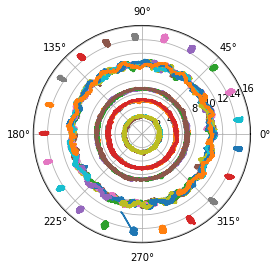

In [16]:
for i,t in trj.groupby("id"):
    plt.polar(t.theta,t.r)

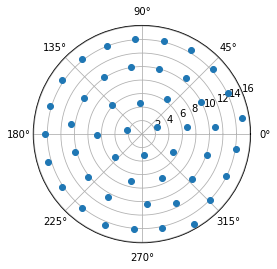

In [25]:
plt.polar(trj.loc[idx[:,0,:],"theta"],trj.loc[idx[:,0,:],"r"],'o')

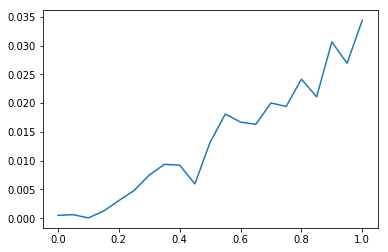

In [18]:
trj["torque"] = (1.5*trj.field)**2
plt.plot(-trj.groupby("torque").mean().omega)

In [19]:
name

'D:\\Experiment25\\Depinning_2019_04_12_14_04_43'

# Iterate preprocessing over all datasets

In [26]:
import warnings; 
warnings.simplefilter('ignore')

omg = [] 
for i,name in tqdm_notebook(enumerate(video_list[:])):
    omg.append(load_preprocess(name,i).groupby(["name","direction","field","layer"]).mean())
    
omg = pd.concat(omg)

In [36]:
omg = pd.concat(omg)

In [57]:
omg.to_csv(os.path.split(directory)[0]+os.path.split(directory)[1]+".dat",sep = "\t")

# Read the angular velocity data 

Since we saved the angular velocities before, we can restart from here

In [1]:
import os
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook
import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

In [2]:
file = r"/Users/aortiza/Desktop/Experiment25.dat"
#field_filename = os.path.join(directory,"Field-12-04-2019.dat")

In [3]:
omg = pd.read_csv(file,sep = "\t", index_col = [0,1,2,3])
omg.head()

r      theta     omega  torque
name direction field    layer                                        
0    bwd       0.149071 0      14.454092   0.141917  0.000088    0.05
                        1      10.426265  -4.802992 -0.001919    0.05
                        2       7.248946 -14.173286 -0.000444    0.05
                        3       3.849596 -16.501549 -0.000774    0.05
               0.210819 0      14.446991   0.141957  0.000131    0.10

## Outer radius variation as time passes

We have observed that the general behaviour of the system changes with time, especially with a new sample. This is likely due to chemical instability, which changes the interaction between particles. One parameter in which this is shown is the radius of the outer layer, which, even though the traps don't move, the change in interaction strength changes the pressure felt by the traped particles.

We will now plot the radius, and choose a region where it doesn't change too much. 

In [4]:
def outer_radius(series):
    return series.loc[idx[:,:,:,0],"r"].mean()

catalogue = omg.groupby("name").apply(outer_radius)
catalogue = pd.DataFrame(catalogue,columns=["r"])

Text(0.5,0,'experiment number (increasing time)')

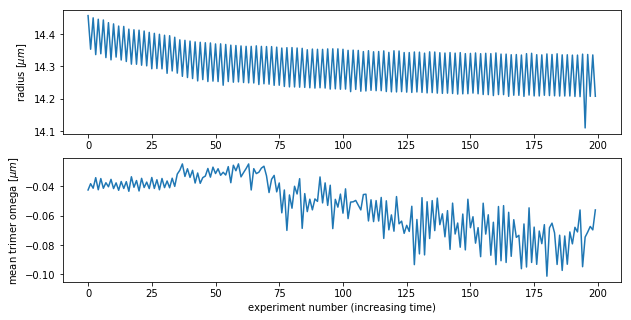

In [5]:
fig, ax = plt.subplots(2,1,figsize = (10,5))

ax[0].plot(omg.groupby(["name","layer"]).mean().loc[idx[:,0],"r"].values)
ax[0].set_ylabel(r"radius [$\mu{}m$]")

ax[1].plot(omg.groupby(["name","layer"]).mean().loc[idx[:,3],"omega"].values)
ax[1].set_ylabel(r"mean trimer omega [$\mu{}m$]")
ax[1].set_xlabel(r"experiment number (increasing time)")

* The zig-zag structure is expected because we are doing tests with two values of radius: $3.45$Hz and $3.5$Hz. 
* We will ignore the first 75 experiments because they have the largest variation of the radius. 
* There is an outlier near the end. We will ignore tests with radius less than 14.15. 

Text(0.5,0,'experiment number (increasing time)')

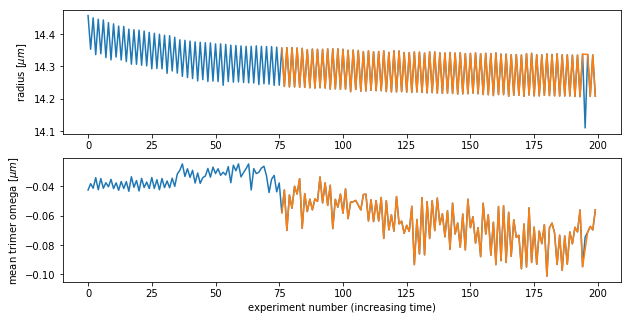

In [6]:
fig, ax = plt.subplots(2,1,figsize = (10,5))

ax[0].plot(
    omg.groupby(["name","layer"]).mean().loc[idx[:,0],"r"].index.get_level_values("name"),
    omg.groupby(["name","layer"]).mean().loc[idx[:,0],"r"].values)
ax[0].set_ylabel(r"radius [$\mu{}m$]")

ax[1].plot(
    omg.groupby(["name","layer"]).mean().loc[idx[:,3],"omega"].index.get_level_values("name"),
    omg.groupby(["name","layer"]).mean().loc[idx[:,3],"omega"].values)
ax[1].set_ylabel(r"mean trimer omega [$\mu{}m$]")
ax[1].set_xlabel(r"experiment number (increasing time)")

omg = omg.loc[omg.index.get_level_values("name")!=catalogue[catalogue.r<14.15].index[0]]
omg = omg.loc[idx[catalogue[catalogue.index>75].index,:],:]

ax[0].plot(
    omg.groupby(["name","layer"]).mean().loc[idx[:,0],"r"].index.get_level_values("name"),
    omg.groupby(["name","layer"]).mean().loc[idx[:,0],"r"].values)
ax[0].set_ylabel(r"radius [$\mu{}m$]")

ax[1].plot(
    omg.groupby(["name","layer"]).mean().loc[idx[:,3],"omega"].index.get_level_values("name"),
    omg.groupby(["name","layer"]).mean().loc[idx[:,3],"omega"].values)
ax[1].set_ylabel(r"mean trimer omega [$\mu{}m$]")
ax[1].set_xlabel(r"experiment number (increasing time)")

There is still a variation of the radius. This is the best we can do.

## Assign a nominal radius to each experiment

We cut the array in two, assigning a nominal radius to each depending on where they fall in the histogram below. 

In [7]:
catalogue = omg.groupby("name").apply(outer_radius)
catalogue = pd.DataFrame(catalogue,columns=["r"])

Text(0.5,0,'radius [$\\mu{}m$]')

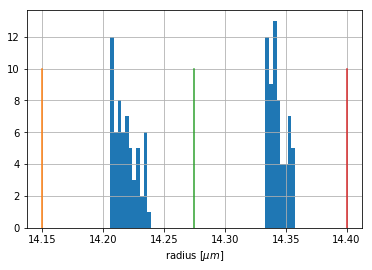

In [8]:
r_lim = np.array([14.15,14.275,14.40])
catalogue.r.hist(bins = 50)
plt.plot([r_lim,r_lim],[np.zeros(len(r_lim)),10*np.ones(len(r_lim))]);
plt.xlabel(r"radius [$\mu{}m$]")

In [9]:
C = pd.cut(catalogue.r, bins = r_lim, labels = [3.45,3.5])

catalogue["r_nom"] = C.cat.categories[C.cat.codes]

In [10]:
omg["torque"] = (1.5*omg.index.get_level_values("field"))**2
omega = pd.DataFrame(omg.groupby(["name","direction","torque","layer"]).mean().omega)

# Resulting Plots

In [58]:
import matplotlib as mpl
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
mpl.rcParams.update({'font.size': 10.5})

In [59]:
"$Phi \sim %2.3f$"%Phi

'$Phi \\sim 0.729$'

/Users/aortiza/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


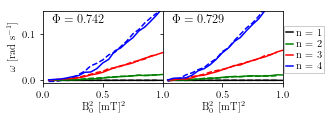

In [62]:
fig = plt.figure(figsize=(13.35/4,13.35*0.3/4),
                 frameon = False)
gs = mpl.gridspec.GridSpec(1, 2,
                           figure=fig, left = 0, right = 1, top = 1, bottom = 0,
                           hspace=0, wspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1],sharey=ax0)
ax = np.array([ax0,ax1])

for i,(r,cat) in enumerate(catalogue.groupby("r_nom")):
    ax[i].set_prop_cycle(color=['black', 'green', 'red','blue'])
    
    r_real = cat.r.mean()/4
    Phi = (15+9+3+21/2)*(2/cat.r.mean())**2
    
    for a,om in omega.loc[idx[cat.index,:,:,:],:].groupby(["direction","layer"]):
        
        #if a[1] == 0:
        #    label = "ring, %s"%(a[0])
        #elif a[1] == 3:
        #    label = "trimer, %s"%(a[0])
        #else:
        if a[0]=="fwd":
            label = "n = %u"%(a[1]+1)
        else:
            label = "_nolabel_"
       
        #label = [r"r=$%s$, %s, l = $%s$"%(r,a[0],a[1])]
        om = om.groupby("torque").mean()
        linestyle = '-'
        if (a[0]=='bwd'):
            linestyle = "--"

        #ax[i].set_title("$r_{nom}$ = %2.2fHz, $r_{real}$ = %2.3fd"%(r,r_real),position=(0.3, 0.9))
        ax[i].set_title(r"$\Phi=%2.3f$"%Phi,position=(0.3, 0.75))

        ax[i].plot(om.index,-om.omega,linestyle,label=label)
        ax[i].set_xlim([0,1])
        ax[i].set_ylim([-0.005,.15])
        ax[i].set_xlabel(r"B$_0^2$ [mT]$^2$")

plt.setp(ax[1].get_yticklabels(), visible=False)
ax[1].set_xlim([0.01,1])
ax[0].set_xlim([0.0,1])
ax[0].set_ylabel(r"$\omega$ [rad s$^{-1}$]")
fig.tight_layout()
#fig.suptitle('angular velocities - Experiment 25 (400 sec loops)')

legend_k = dict(loc='upper left',
                bbox_to_anchor=(1, 0.8),
                borderpad=0.2,
                framealpha = 1,
                labelspacing = 0.1,
                handlelength = 0.7,
                handletextpad =0.2,
                borderaxespad = 0.1,
                fancybox = False)


ax[-1].legend(**legend_k)
fig.savefig(os.path.join('depinning.pdf'),pad_inches=0.01,bbox_inches='tight')


### We'll zoom in to the depinning zone

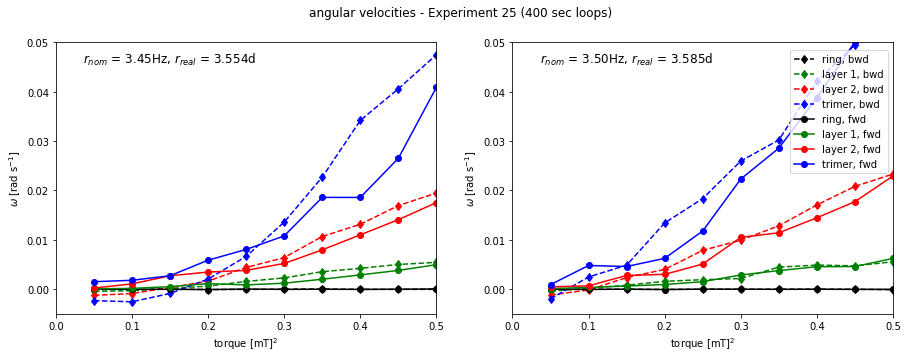

In [12]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()

for i,(r,cat) in enumerate(catalogue[catalogue.index>100].groupby("r_nom")):
    ax[i].set_prop_cycle(color=['black', 'green', 'red','blue'])
    
    r_real = cat.r.mean()/4
    
    for a,om in omega.loc[idx[cat.index,:,:,:],:].groupby(["direction","layer"]):
        
        if a[1] == 0:
            label = "ring, %s"%(a[0])
        elif a[1] == 3:
            label = "trimer, %s"%(a[0])
        else:
            label = "layer %u, %s"%(a[1],a[0])
       
        #label = [r"r=$%s$, %s, l = $%s$"%(r,a[0],a[1])]
        om = om.groupby("torque").mean()
        linestyle = '-'
        marker = 'o'
        if (a[0]=='bwd'):
            linestyle = "--"
            marker = 'd'

        ax[i].set_title("$r_{nom}$ = %2.2fHz, $r_{real}$ = %2.3fd"%(r,r_real),position=(0.3, 0.9))

        ax[i].plot(om.index,-om.omega,linestyle,label=label,marker = marker)
        ax[i].set_xlim([0,.5])
        ax[i].set_ylim([-0.005,.05])
        ax[i].set_xlabel(r"torque [mT]$^2$")
        ax[i].set_ylabel(r"$\omega$ [rad s$^{-1}$]")

        
fig.suptitle('angular velocities - Experiment 25 (400 sec loops)')
ax[-1].legend(bbox_to_anchor=(1, 0.5))

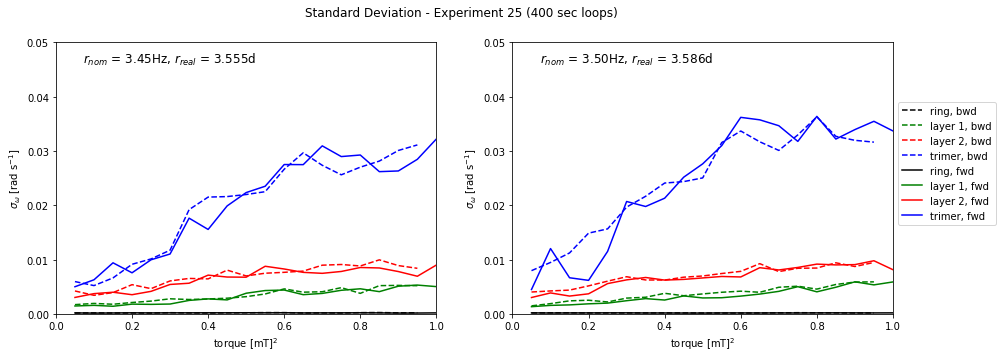

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()

for i,(r,cat) in enumerate(catalogue.groupby("r_nom")):
    ax[i].set_prop_cycle(color=['black', 'green', 'red','blue'])
    
    r_real = cat.r.mean()/4
    
    for a,om in omega.loc[idx[cat.index,:,:,:],:].groupby(["direction","layer"]):
        
        if a[1] == 0:
            label = "ring, %s"%(a[0])
        elif a[1] == 3:
            label = "trimer, %s"%(a[0])
        else:
            label = "layer %u, %s"%(a[1],a[0])
       
        #label = [r"r=$%s$, %s, l = $%s$"%(r,a[0],a[1])]
        om = om.groupby("torque").std()
        linestyle = '-'
        if (a[0]=='bwd'):
            linestyle = "--"

        ax[i].set_title("$r_{nom}$ = %2.2fHz, $r_{real}$ = %2.3fd"%(r,r_real),position=(0.3, 0.9))

        ax[i].plot(om.index,om.omega,linestyle,label=label)
        ax[i].set_xlim([0,1])
        ax[i].set_ylim([0,.05])
        ax[i].set_xlabel(r"torque [mT]$^2$")
        ax[i].set_ylabel(r"$\sigma_\omega$ [rad s$^{-1}$]")

        
fig.suptitle('Standard Deviation - Experiment 25 (400 sec loops)')
ax[-1].legend(bbox_to_anchor=(1, 0.8))